# Proyek Klasifikasi Gambar: [Waste Classification](https://www.kaggle.com/datasets/techsash/waste-classification-data)
- **Nama:** Muhammad Tsaqif
- **Email:** mtsaqif08@gmail.com
- **ID Dicoding:** MC004D5Y2062

## Import Library

In [20]:
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import json
import collections
import pickle

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.auto import tqdm
from IPython.display import display, HTML
from google.colab import files
import ipywidgets as widgets
from io import BytesIO

import cv2
import kagglehub
import tensorflow as tf
import tensorflowjs as tfjs
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models, regularizers, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [2]:
# Setup GPU untuk mempercepat training
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

## Data Preparation

In [3]:
# Fungsi untuk mengecek resolusi gambar
def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.add(img.size)

        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")

    print(f"\nTotal: {total_images}")

### Data Loading

In [4]:
print("Downloading dataset...")
try:
    dataset_path = kagglehub.dataset_download("techsash/waste-classification-data")
    print(f"Dataset path: {dataset_path}")
except Exception as e:
    print(f"Failed to download dataset: {e}")

Dataset path: /kaggle/input/waste-classification-data


In [5]:
# Define paths
train_path = os.path.join(dataset_path, "DATASET/TRAIN")
test_path = os.path.join(dataset_path, "DATASET/TEST")

In [6]:
# Verifikasi resolusi gambar
print("\nChecking image resolutions in training set:")
print_images_resolution(train_path)


Checking image resolutions in training set:
R: 9999
- (77, 252)
- (410, 123)
- (206, 244)
- (315, 160)
- (141, 273)
- (253, 194)
- (360, 140)
- (177, 284)
- (201, 251)
- (221, 229)
- (186, 271)
- (189, 267)
- (150, 196)
- (276, 183)
- (88, 221)
- (226, 191)
- (334, 151)
- (280, 180)
- (365, 138)
- (272, 185)
- (220, 147)
- (257, 196)
- (292, 172)
- (141, 250)
- (80, 243)
- (484, 104)
- (284, 177)
- (173, 291)
- (380, 132)
- (209, 241)
- (165, 305)
- (93, 209)
- (306, 164)
- (252, 193)
- (349, 144)
- (298, 169)
- (276, 169)
- (244, 207)
- (233, 216)
- (376, 134)
- (345, 146)
- (182, 268)
- (169, 298)
- (237, 213)
- (325, 155)
- (356, 142)
- (228, 222)
- (201, 250)
- (221, 228)
- (192, 192)
- (224, 224)
- (236, 189)
- (186, 270)
- (513, 98)
- (189, 266)
- (330, 153)
- (276, 182)
- (417, 121)
- (217, 194)
- (394, 128)
- (225, 225)
- (160, 315)
- (241, 160)
- (216, 234)
- (336, 150)
- (282, 179)
- (274, 184)
- (422, 119)
- (399, 126)
- (83, 235)
- (294, 171)
- (160, 180)
- (180, 195)
- (2

### Data Preprocessing

In [7]:
# Fungsi untuk memuat dataset dengan augmentasi
def load_dataset(base_path, image_size=(224, 224), batch_size=32, augment=False):
    def process_image(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [256, 256])  # Resize ke ukuran lebih besar dulu
        img = tf.image.random_crop(img, size=[image_size[0], image_size[1], 3])  # Random crop ke ukuran target
        img = tf.cast(img, tf.float32) / 255.0

        if augment:
            img = tf.image.random_flip_left_right(img)
            if tf.random.uniform(()) > 0.5:
                img = tf.image.random_brightness(img, max_delta=0.1)
                img = tf.image.random_contrast(img, lower=0.9, upper=1.1)
            img = tf.clip_by_value(img, 0.0, 1.0)

        return img, label

    image_paths = []
    labels = []
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(root, file))
                labels.append(os.path.basename(root))

    le = LabelEncoder()
    labels_encoded = le.fit_transform(labels)

    ds = tf.data.Dataset.from_tensor_slices((image_paths, labels_encoded))
    ds = ds.shuffle(len(image_paths)) if augment else ds
    ds = ds.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds, le

#### Split Dataset

In [8]:
# Memuat dataset dengan augmentasi untuk training dan tanpa augmentasi untuk test
train_ds, le = load_dataset(train_path, augment=True, batch_size=64)
test_ds, _ = load_dataset(test_path, batch_size=64)

# Split Dataset
# 80% training, 10% validation, 10% test (test set sudah terpisah)
train_size = int(0.8 * len(train_ds))
val_ds = train_ds.skip(train_size)
train_ds = train_ds.take(train_size)

# Hitung class weights untuk menangani imbalance class
print("\nCalculating class weights...")
all_labels = np.concatenate([y for x, y in train_ds], axis=0)
class_weights = compute_class_weight('balanced', classes=np.unique(all_labels), y=all_labels)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)


Calculating class weights...
Class weights: {0: np.float64(0.8979998009752214), 1: np.float64(1.1281410176272033)}


Jumlah data training: 18048
Jumlah data validation: 4516
Jumlah data test: 2513
Total seluruh data: 25077

Distribusi kelas pada training set:
O: 10031 samples
R: 8017 samples


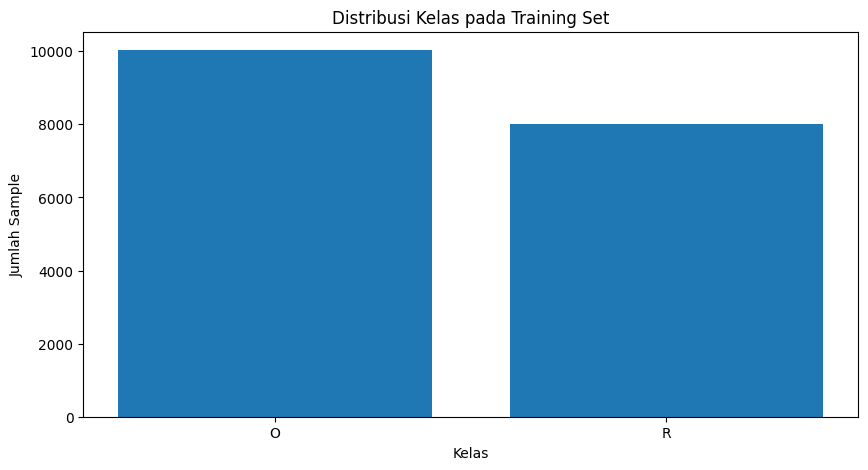


Jumlah kelas: 2
Nama kelas: [np.str_('O'), np.str_('R')]


In [9]:
# Menghitung jumlah data pada setiap set
def count_data(dataset):
    count = 0
    for _, labels in dataset:
        count += labels.shape[0]
    return count

train_count = count_data(train_ds)
val_count = count_data(val_ds)
test_count = count_data(test_ds)

print(f"Jumlah data training: {train_count}")
print(f"Jumlah data validation: {val_count}")
print(f"Jumlah data test: {test_count}")
print(f"Total seluruh data: {train_count + val_count + test_count}")

# Menghitung distribusi kelas pada training set
print("\nDistribusi kelas pada training set:")
train_classes = np.concatenate([y for x, y in train_ds], axis=0)
unique, counts = np.unique(train_classes, return_counts=True)
for cls, cnt in zip(unique, counts):
    print(f"{le.classes_[cls]}: {cnt} samples")

# Visualisasi distribusi kelas
plt.figure(figsize=(10, 5))
plt.bar(le.classes_, counts)
plt.title('Distribusi Kelas pada Training Set')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Sample')
plt.show()

# Verifikasi jumlah kelas
print(f"\nJumlah kelas: {len(le.classes_)}")
print(f"Nama kelas: {list(le.classes_)}")

## Modelling

In [10]:
def build_model(input_shape=(224, 224, 3)):
    model = Sequential([
        # Enhanced Stem Block
        layers.Conv2D(32, (7, 7), strides=2, padding='same', activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=2, padding='same'),

        # Inception-like Block
        layers.Conv2D(64, (1, 1), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Convolution Block
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), strides=2, padding='same', activation='relu'),
        layers.BatchNormalization(),

        # Convolution Block
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Final Layers
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Membangun model
print("\nBuilding model...")
sequential_model = build_model()
sequential_model.summary()


Building model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 112, 112, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 56, 56, 64)     │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 826,241 (3.15 MB)

 Trainable params: 824,897 (3.15 MB)

 Non-trainable params: 1,344 (5.25 KB)

In [11]:
# Kompilasi model dengan pengaturan optimal
model = build_model()
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Callbacks untuk meningkatkan akurasi
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    EarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True)
]

In [12]:
# Training model
print("\nStarting training...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    class_weight=class_weights,
    callbacks=callbacks
)


Starting training...
Epoch 1/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 82s 233ms/step - accuracy: 0.8074 - auc: 0.8794 - loss: 3.3368 - val_accuracy: 0.5241 - val_auc: 0.7386 - val_loss: 0.9834 - learning_rate: 0.0010
Epoch 2/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 53s 189ms/step - accuracy: 0.8407 - auc: 0.9094 - loss: 0.4203 - val_accuracy: 0.8016 - val_auc: 0.8879 - val_loss: 0.4632 - learning_rate: 0.0010
Epoch 3/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 52s 185ms/step - accuracy: 0.8447 - auc: 0.9142 - loss: 0.3905 - val_accuracy: 0.8417 - val_auc: 0.9179 - val_loss: 0.4019 - learning_rate: 0.0010
Epoch 4/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 83s 187ms/step - accuracy: 0.8542 - auc: 0.9207 - loss: 0.3746 - val_accuracy: 0.6902 - val_auc: 0.9093 - val_loss: 0.6015 - learning_rate: 0.0010
Epoch 5/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 95s 234ms/step - accuracy: 0.8652 - auc: 0.9285 - loss: 0.3575 - val_accuracy: 0.6145 - val_auc: 0.9194 - val_loss: 0.9170 - learning_rate: 0.0010
Epoch 6/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 68s

## Evaluasi dan Visualisasi

In [13]:
print("\nEvaluating on test set...")
test_loss, test_acc, test_auc = model.evaluate(test_ds)
print(f"\nTest loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")


Evaluating on test set...
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.8756 - auc: 0.5691 - loss: 0.3346

Test loss: 0.2406
Test accuracy: 0.9148
Test AUC: 0.9714


In [14]:
# Ekstrak label sebenarnya dan prediksi
y_true = []
y_pred_probs = []

for images, labels in tqdm(test_ds, desc="Evaluating"):
    probas = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred_probs.extend(probas.flatten())

# Konversi probabilitas ke kelas (threshold 0.5)
y_pred = (np.array(y_pred_probs) > 0.5).astype(int)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]


Classification Report:
              precision    recall  f1-score   support

           O       0.89      0.97      0.92      1401
           R       0.95      0.84      0.89      1112

    accuracy                           0.91      2513
   macro avg       0.92      0.90      0.91      2513
weighted avg       0.91      0.91      0.91      2513



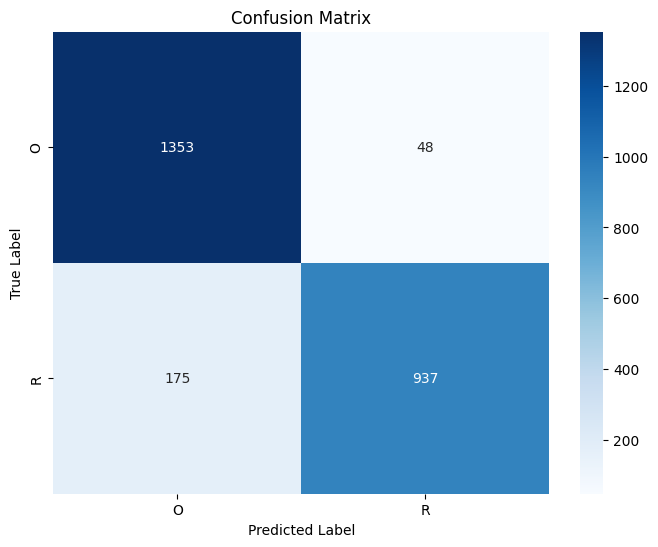

In [15]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

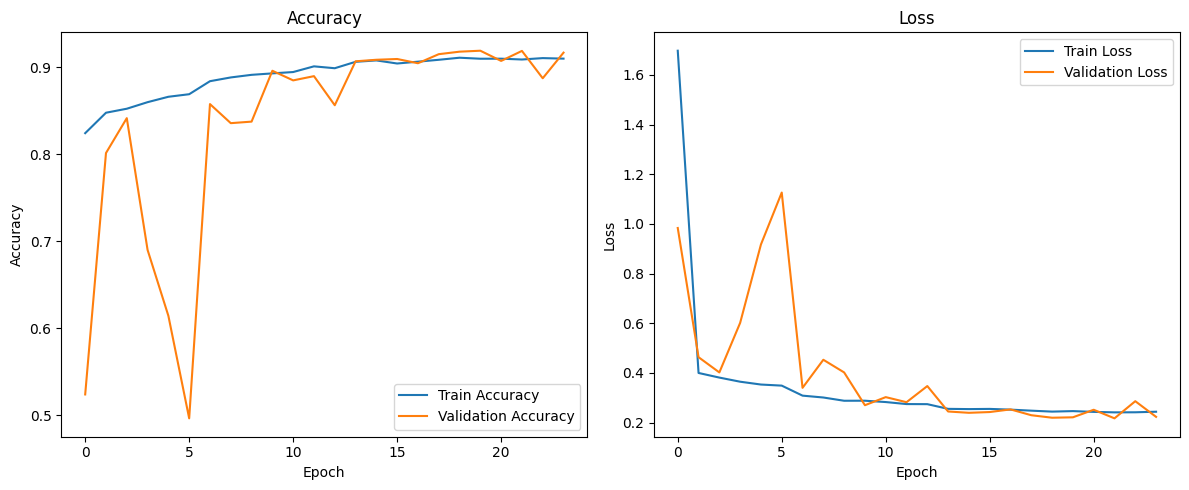

In [16]:
# Plot training history (akurasi dan loss)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Konversi Model

In [17]:
# Membuat direktori untuk menyimpan model
os.makedirs('tfjs_model', exist_ok=True)
os.makedirs('tflite', exist_ok=True)
os.makedirs('saved_model', exist_ok=True)

# 1. Menyimpan sebagai SavedModel format
print("Saving as SavedModel...")
tf.saved_model.save(model, 'saved_model')

# 2. Menyimpan sebagai TF-Lite format
print("Converting to TFLite...")

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
with open('tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

# Save labels
with open('tflite/label.txt', 'w') as f:
    f.write('\n'.join(le.classes_))

# 3. Menyimpan sebagai TFJS format
print("Converting to TFJS...")
tfjs.converters.save_keras_model(model, 'tfjs_model')

print("All models saved successfully!")

Saving as SavedModel...
Converting to TFLite...
Saved artifact at '/tmp/tmpnsw65rpm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_22')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  136132479050256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136132479052752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136132479052944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136132479052176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136132479051408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136132479052560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136132479054480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136132479055056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136132479055248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136132479054096: TensorSpec(shape

Converting to TFJS...
failed to lookup keras version from the file,
    this is likely a weight only file
All models saved successfully!


## Inference

In [28]:
# Load model yang sudah disimpan
loaded_model = tf.saved_model.load('submission/saved_model')

# Fungsi untuk preprocessing gambar
def preprocess_image(image_bytes, target_size=(224, 224)):
    img = Image.open(BytesIO(image_bytes)).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Fungsi untuk melakukan prediksi
def predict(image_bytes):
    # Preprocess gambar
    input_tensor = preprocess_image(image_bytes)

    # Lakukan prediksi - gunakan nama output yang benar
    infer = loaded_model.signatures["serving_default"]
    predictions = infer(tf.constant(input_tensor.astype('float32')))

    # Dapatkan output - ambil output pertama jika tidak tahu namanya
    output_name = list(predictions.keys())[0]
    output = predictions[output_name].numpy()[0][0]

    class_idx = 1 if output > 0.5 else 0
    confidence = output if class_idx == 1 else 1 - output
    class_name = le.classes_[class_idx]

    return class_name, confidence, output_name

# Widget untuk upload gambar
upload_btn = widgets.FileUpload(
    accept='image/*',
    multiple=False,
    description='Pilih Gambar'
)

# Output widget untuk menampilkan hasil
out_pl = widgets.Output()
lbl_pred = widgets.Label()

def on_upload_change(change):
    if not upload_btn.value:
        return

    lbl_pred.value = 'Memproses...'

    try:
        # Ambil file yang diupload
        uploaded_file = list(upload_btn.value.values())[0]
        image_bytes = uploaded_file['content']

        # Lakukan prediksi
        class_name, confidence, output_name = predict(image_bytes)

        # Tampilkan hasil
        with out_pl:
            out_pl.clear_output()

            # Tampilkan gambar
            img = Image.open(BytesIO(image_bytes))
            plt.figure(figsize=(8, 4))
            plt.subplot(1, 2, 1)
            plt.imshow(img)
            plt.title('Gambar Input')
            plt.axis('off')

            # Tampilkan grafik prediksi
            plt.subplot(1, 2, 2)
            plt.bar(le.classes_, [1-confidence, confidence] if class_name == 'R' else [confidence, 1-confidence])
            plt.title(f'Prediksi: {class_name} (via {output_name})\nConfidence: {confidence:.2%}')
            plt.ylabel('Probability')
            plt.ylim(0, 1)
            plt.show()

        lbl_pred.value = f'Hasil: {class_name} (Confidence: {confidence:.2%})'

    except Exception as e:
        lbl_pred.value = f'Error: {str(e)}'
        with out_pl:
            out_pl.clear_output()
            print(f'Terjadi error: {str(e)}')

upload_btn.observe(on_upload_change, names='value')

# Tampilkan semua widget
display(widgets.VBox([
    widgets.Label('Upload Gambar Sampah untuk Diklasifikasikan:'),
    upload_btn,
    lbl_pred,
    out_pl
]))